# Page Rank Feature Selection algorithm evaluation

This notebook contains all the experiments that have been done to test the performance of the PageRank Feature Selection algorithm. It is part of the report of the final thesis of Josep Medialdea.

# Imports

In [3]:
import time
import pandas as pd
from prfs.feature_selection import PageRankFeatureSelector
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR, SVC
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt

# Dataset initialization

<AxesSubplot:>

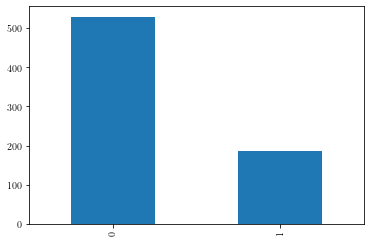

In [126]:
dataset_name = 'titanic'
drop_columns = []

dataset = pd.read_csv(f'datasets/{dataset_name}.csv').drop(columns=drop_columns)
features = dataset.iloc[:, 1:]
target = dataset.iloc[:,0]

dataset.iloc[:, -1].value_counts().plot(kind='bar')

dataset = pd.read_csv(f'datasets/titanic-train.csv').drop(columns=['PassengerId', 'Name', 'Ticket', 'Embarked'])
dataset.loc[dataset.Sex == 'male', 'Sex'] = 0
dataset.loc[dataset.Sex == 'female', 'Sex'] = 1
dataset.loc[dataset['Cabin'].isnull(), 'Cabin'] = 0
dataset.loc[dataset.Cabin != 0, 'Cabin'] = 1
dataset.dropna(axis='index', inplace=True)
dataset.to_csv('datasets/titanic.csv', index=False)
dataset.head()

# Feature selection

In [170]:
prfs_params = {
    'graph':  'feature_label',
    'alpha':  'accuracy',
    'beta':   'accuracy',
    'weight':  0.5
}

In [171]:
prfs = PageRankFeatureSelector(**prfs_params)
t1 = time.perf_counter_ns()
prfs.fit(features, target)
t2 = time.perf_counter_ns()
print(t2 - t1)
print(prfs.ranking())

119371579
RANKING
------
1: Sex
2: Cabin
3: Pclass
4: Fare
5: Age
6: Parch
7: SibSp



8


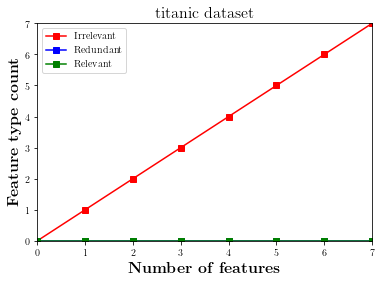

In [172]:
n_relevant = [0]
n_redundant = [0]
n_irrelevant = [0]

for i in range(len(features.columns)):
    rel = 0
    red = 0
    irr = 0
    for feature_name in prfs.select(i + 1):
        if 'dice' in feature_name or ('relevant' in feature_name and not 'irrelevant' in feature_name):
            rel += 1
        elif 'sum' in feature_name or 'redundant' in feature_name:
            red += 1
        else:
            irr += 1
    n_relevant.append(rel)
    n_redundant.append(red)
    n_irrelevant.append(irr)

print(len(n_relevant))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'\textbf{Number of features}',fontsize=16)
plt.ylabel(r'\textbf{Feature type count}',fontsize=16)
plt.title(f'{dataset_name} dataset', fontsize=16)
plt.plot(range(0, len(n_irrelevant)), n_irrelevant, marker='s', color='r', label='Irrelevant')
plt.plot(range(0, len(n_redundant)), n_redundant, marker='s', color='b', label='Redundant')
plt.plot(range(0, len(n_relevant)), n_relevant, marker='s', color='g', label='Relevant')
plt.xlim([0, len(features.columns)])
plt.ylim([0, len(features.columns)])
plt.legend()
plt.savefig(f"figures/type_{dataset_name}_{prfs_params['graph']}_{prfs_params['alpha']}_{prfs_params['beta']}_{prfs_params['weight']}.png", dpi=400)
plt.show()

# Classifier evaluation

In [173]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.40, random_state=42)

accuracy_decision_tree = []
accuracy_naive_bayes = []
accuracy_svc = []

decision_tree_time = []
naive_bayes_time = []
svc_time = []

for n in range(len(features.columns)):
    clf = DecisionTreeClassifier()
    t1 = time.perf_counter_ns()
    clf.fit(X_train[prfs.select(n + 1)], y_train)
    t2 = time.perf_counter_ns()
    decision_tree_time.append(t2 - t1)
    accuracy_decision_tree.append(clf.score(X_test[prfs.select(n + 1)], y_test))
    
    clf = GaussianNB()
    t1 = time.perf_counter_ns()
    clf.fit(X_train[prfs.select(n + 1)], y_train)
    t2 = time.perf_counter_ns()
    naive_bayes_time.append(t2 - t1)
    accuracy_naive_bayes.append(clf.score(X_test[prfs.select(n + 1)], y_test))
    
    clf = SVC()
    t1 = time.perf_counter_ns()
    clf.fit(X_train[prfs.select(n + 1)], y_train)
    t2 = time.perf_counter_ns()
    svc_time.append(t2 - t1)
    accuracy_svc.append(clf.score(X_test[prfs.select(n + 1)], y_test))

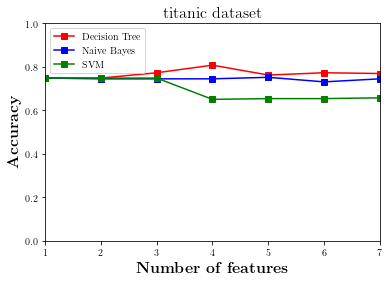

In [174]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'\textbf{Number of features}',fontsize=16)
plt.ylabel(r'\textbf{Accuracy}',fontsize=16)
plt.title(f'{dataset_name} dataset', fontsize=16)
plt.plot(range(1, len(accuracy_decision_tree) + 1), accuracy_decision_tree, marker='s', color='r', label='Decision Tree')
plt.plot(range(1, len(accuracy_naive_bayes) + 1), accuracy_naive_bayes, marker='s', color='b', label='Naive Bayes')
plt.plot(range(1, len(accuracy_svc) + 1), accuracy_svc, marker='s', color='g', label='SVM')
plt.xlim([1, len(features.columns)])
plt.ylim([0, 1])
plt.legend()
plt.savefig(f"figures/accuracy_{dataset_name}_{prfs_params['graph']}_{prfs_params['alpha']}_{prfs_params['beta']}_{prfs_params['weight']}.png", dpi=400)
plt.show()

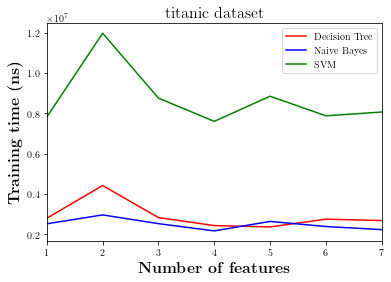

In [159]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'\textbf{Number of features}',fontsize=16)
plt.ylabel(r'\textbf{Training time (ns)}',fontsize=16)
plt.title(f'{dataset_name} dataset', fontsize=16)
plt.plot(range(1, len(decision_tree_time) + 1), decision_tree_time, color='r', label='Decision Tree')
plt.plot(range(1, len(naive_bayes_time) + 1), naive_bayes_time, color='b', label='Naive Bayes')
plt.plot(range(1, len(svc_time) + 1), svc_time, color='g', label='SVM')
plt.xlim([1, len(features.columns)])
plt.savefig('dice3_time.png')

plt.legend()
plt.show()

# Regressor evaluation

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

r2_svm = []

for n in range(len(features.columns)):
    ref = SVR()
    ref.fit(X_train[prfs.select(n + 1)], y_train)
    r2_svm.append(ref.score(X_test[prfs.select(n + 1)], y_test))

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'Number of features',fontsize=16)
plt.ylabel(r'\textbf{$R^2$}',fontsize=16)
plt.title(f'{dataset_name} dataset', fontsize=16)
plt.plot(range(1, len(r2_svm) + 1), r2_svm, marker='s', color='r', label='SVM')
plt.xlim([1, len(features.columns)])
plt.ylim([0, 1])
plt.legend()
plt.show()